# Using NP4VTT: Local logit

In this notebook, we show how to use a local (weighted) logit to estimate the distribution of the Value of Travel Time (VTT) from the Norway data.

## Step 1: Load modules and data, and create arrays

We first import the NP4VTT modules for creating the arrays, the local logit, and Pandas to load the dataset:

In [1]:
import sys
sys.path.append('../src')

In [2]:
import pandas as pd
from py_np4vtt.data_format import StudyVar
from py_np4vtt.model_loclogit import ModelLocLogit, ConfigLocLogit
from py_np4vtt.data_import import make_modelarrays, compute_descriptives

Now we read the CSV file:

In [3]:
df = pd.read_table('../data/Norway09_data_v5.txt')
df.head()

,RespID,Mode,TravTime,BaseCost,Gender,AgeClass,IncClass,TravTimeClass,Purpose,CardID,...,TimeL,TimeR,Chosen,Quadrant2,Purpose2,Mode2,Income2,ExclGroup,Exclude_CDF,CS
0,88,1,25,27,1,3,5,1,1,1,...,32,25,1,4,1,1,3,4,1,1
1,88,1,25,27,1,3,5,1,1,2,...,25,28,2,2,1,1,3,4,1,2
2,88,1,25,27,1,3,5,1,1,3,...,29,25,1,4,1,1,3,4,1,3
3,88,1,25,27,1,3,5,1,1,4,...,32,25,1,2,1,1,3,4,1,4
4,88,1,25,27,1,3,5,1,1,5,...,29,32,2,2,1,1,3,4,1,5


The dataset contains 22 variables. Each row is a binary choice task. We will use:

* `RespID`: ID of each respondent.
* `Chosen`: Chosen alternative.
* `CostL`: Travel cost of alternatives 1 [NOK]
* `CostR`: Travel cost of alternatives 2 [NOK]
* `TimeL`: Travel time of alternatives 1 [minutes]
* `TimeR`: Travel time of alternatives 2 [minutes]

NP4VTT detects automatically the _slow and cheap_ and _fast and expensive_ alternative, for each choice situation. If NP4VTT finds violations to those two options (e.g., a fast-cheap) alternative, it will raise an error message.

Change currency of travel time to euros and change unit of travel time to hours

In [4]:
# Convert to euros
NOK2euro_exchange_rate = 9
df[['CostL','CostR']] = df[['CostL','CostR']] .div(NOK2euro_exchange_rate)

# convert to hours
df[['TimeL','TimeR']] = df[['TimeL','TimeR']] .div(60)

Now we create a dictionary to map the required variables for NP4VTT with the variables of the dataset:

In [5]:
columnarrays = {
    StudyVar.Id: 'RespID',
    StudyVar.ChosenAlt: 'Chosen',
    StudyVar.Cost1: 'CostL',
    StudyVar.Cost2: 'CostR',
    StudyVar.Time1: 'TimeL',
    StudyVar.Time2: 'TimeR',
}

And we create the required arrays:

In [6]:
model_arrays = make_modelarrays(df, columnarrays)

The function `make_modelarrays` creates six elements used by NP4VTT to estimate/train a model:

* `BVTT`: Contains the Boundary VTT per choice situation, computed from costs and time.
* `Choice`: A matrix of dummy variables that are equal to one if the respondent choose the fast-expensive alternative on each choice situation.
* `Accepts`: Number of times a respondent chose the fast-expensive alternative.
* `ID`: Unique identifier of each respondent.
* `NP`: Number of respondents in the dataset.
* `T`: Number of choice situations per respondent.

## Step 2: Compute descriptives

The function `compute_descriptives` provides a small overview of the dataset characteristics:

In [7]:
descriptives = compute_descriptives(model_arrays)
print(descriptives)

No. individuals: 5832
Sets per indiv.: 9

Number of non-traders:
Fast-exp. alt.: 144
Slow-cheap alt.: 808

BVTT statistics:
Mean chosen BVTT: 3.5800867802855794
Minimum of BVTT: 0.6666666666666644
Maximum of BVTT: 113.56321839080461


## Step 3: Configure the local logit

The local logit requires the following parameters from the user:

* `minimum`: The minimum of the VTT grid.
* `maximum`: The maximum of the VTT grid.
* `supportPoints`: The number of support points.

Based on the descriptive statistics, we create a VTT grid in the range of 0 (minimum) and 100 (maximum), with 21 support points. Hence, the VTT grid is defined on intervals of one.

The function `ConfigLocLogit` takes the configuration parameters of the local logit and creates an object that is used by the optimisation routine:

In [8]:
config = ConfigLocLogit(minimum=0, maximum=100, supportPoints=26)

Now, we create the Local logit object that contains the configuration parameters and the data arrays. Then, we initialise the model:

In [9]:
loclogit = ModelLocLogit(config, model_arrays)
initialArgs = loclogit.setupInitialArgs()

`setupInitialArgs` creates the following specific arrays for the Local Logit model:

- `vtt_grid`: the VTT grid as specified in `ConfigLocalLogit`.
- `k`: The kernel width used in the estimation routine.
- `YX`: The flattened version of the dependent variable.

## Step 4: Estimate a local logit

Once the local logit object is initialised, the `run` method starts the optimisation process:

In [10]:
p, vtt_grid, fval = loclogit.run(initialArgs)

The estimated model returns the following information:

* `p:` The cumulative choice probability at each interval of the VTT grid.
* `fval:` Value of the likelihood function in the optimum.
* `vtt_grid:` The VTT grid used in the estimation routine.

The following lines present the estimated results:

In [14]:
# Create dataframe
results = pd.Series(p,name='Cum. Prob.',index=vtt_grid[1:].astype(int))

print('Estimation results:\n')
print('Final log-likelihood: ' + str(round(fval,2)))
print('\nEstimated Cumulative probability:')
print(results)

Estimation results:

Final log-likelihood: -27533.32

Estimated Cumulative probability:
4      0.056955
8      0.329410
12     0.533628
16     0.669800
20     0.749651
24     0.806891
28     0.828791
32     0.845790
36     0.864154
40     0.889341
44     0.911403
48     0.912003
52     0.919364
56     0.927771
60     0.936401
64     0.920470
68     0.920644
72     0.922820
76     0.930101
80     0.963296
84     0.953756
88     0.960200
92     0.933064
96     0.927572
100    0.950630
Name: Cum. Prob., dtype: float64


## Step 5: Visualising the VTT distribution

We create the empirical Cumulative Density Function plot of the VTT distribution. For easy interpretation, we use create a histogram from the CDF. 
We use matplotlib for this:

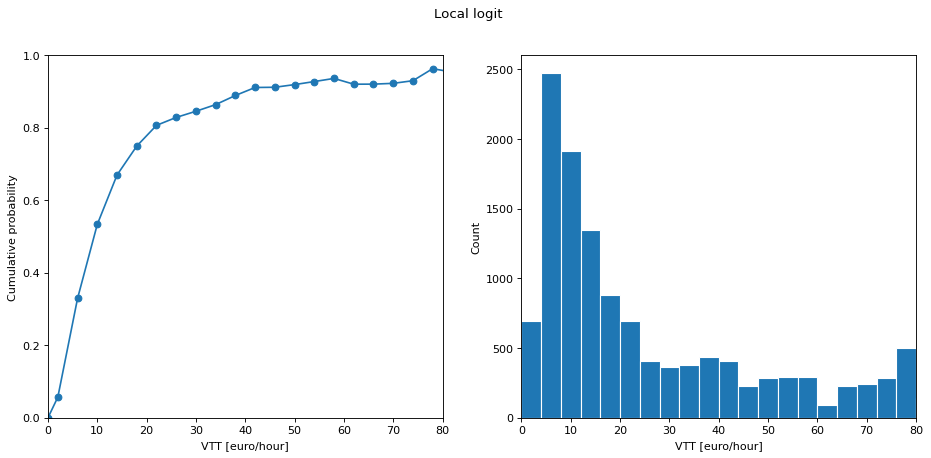

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Obtain the midpoints from the vtt_grid
vtt_grid_midpoints = ((np.append(vtt_grid, 0) + np.append(0,vtt_grid)))/2
vtt_grid_midpoints[-1] = vtt_grid[-1]

fig, ax = plt.subplots(1,2,figsize=(14,6), dpi=80)

# Plot CDF
ax[0].plot(vtt_grid_midpoints,np.concatenate((0,p,p[-1]),axis=None),marker='o')
ax[0].set_xlim(0,80)
ax[0].set_ylim(0,1)
ax[0].set_xlabel('VTT [euro/hour]')
ax[0].set_ylabel('Cumulative probability')

# Obtain probabilities from the CDF plot
pp = ((np.append(p, 0)-np.append(0,p)))
pp = pp + np.abs(np.min(pp[:-1]))
pp = (np.divide(pp,np.sum(pp)))
pp[-1] = 0
pp = np.append(0,pp)

# Construct data points
data_hist = []
for n in range(0,len(vtt_grid_midpoints)):
    dat = [vtt_grid_midpoints[n]]*np.round((pp[n]*descriptives.NP)).astype(int)
    data_hist = np.append(data_hist,dat)

# Plot histogram
ax[1].set_xlim(0,80)
ax[1].set_xlabel('VTT [euro/hour]')
ax[1].set_ylabel('Count')
ax[1].hist(data_hist, bins = vtt_grid,edgecolor="white")
fig.suptitle('Local logit')
plt.show()